## SQL: Color Survey

In [298]:
import sqlite3 as sql
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
conn = sql.connect('mainsurvey.db')

What's in **answers**?

In [3]:
pd.read_sql_query('SELECT * FROM answers LIMIT 10;', conn)

,id,user_id,datestamp,r,g,b,colorname
0,1,1,1.267419e+09,72,100,175,pastel blue
1,2,1,1.267419e+09,204,177,246,faint violet
2,3,1,1.267419e+09,182,226,245,baby blue
3,4,1,1.267419e+09,130,64,234,purple
4,5,2,1.267419e+09,75,49,234,blue
5,6,2,1.267419e+09,76,215,249,light blue
6,7,2,1.267419e+09,111,145,122,olive green
7,8,2,1.267419e+09,88,70,1,brown
8,9,2,1.267419e+09,218,35,156,pink
9,10,4,1.267419e+09,154,42,159,purple


What's in **users**?

In [4]:
pd.read_sql_query('SELECT * FROM users LIMIT 5;', conn)

,id,user_key,datestamp,ip,language,monitor,temperature,gamma,colorblind,ychrom,samplecolors,spamprob
0,1,1irzBJF4C4MNNn5H3Ww7SFNRvqSUG,1.267419e+09,0.0.0.0,None,LCD,6500.0,2.2,0,1,blue/royal periwinkle,0.002088
1,2,1hW1tdQ5iCxFnIy4Xpc3ckh18ZDL,1.267419e+09,0.0.0.0,None,LCD,6500.0,NaN,0,1,pink/pale salmon,0.074577
2,3,1GI5SzNKh6ntR5mhD494MkZG0s4Zk1,1.267419e+09,0.0.0.0,None,LCD,NaN,NaN,0,1,green/light olive,0.016404
3,4,18l2GajPo4ptcw1YTXKRm1Xn8jEfNN,1.267419e+09,0.0.0.0,None,LCD,NaN,NaN,0,0,green/light olive,0.001562
4,5,1Qd1F6Oi9B4E6c7xInaDeqIRxmJevx1,1.267419e+09,0.0.0.0,None,LCD,6500.0,2.2,0,1,brown/raw umber,0.002381


From **answers**, check out the id, user_id, r, b, g, and color names

In [5]:
pd.read_sql_query('SELECT id,user_id,r,g,b,colorname FROM answers LIMIT 5;', conn)

,id,user_id,r,g,b,colorname
0,1,1,72,100,175,pastel blue
1,2,1,204,177,246,faint violet
2,3,1,182,226,245,baby blue
3,4,1,130,64,234,purple
4,5,2,75,49,234,blue


From **users**, check out the id, color blind, sex, and sample colors

In [6]:
pd.read_sql_query('SELECT id,colorblind,ychrom,samplecolors FROM users LIMIT 5;', conn)

,id,colorblind,ychrom,samplecolors
0,1,0,1,blue/royal periwinkle
1,2,0,1,pink/pale salmon
2,3,0,1,green/light olive
3,4,0,0,green/light olive
4,5,0,1,brown/raw umber


Join these **two** together

In [7]:
joined_df = pd.read_sql_query('SELECT * FROM answers INNER JOIN users ON users.id = answers.user_id;', conn)

In [8]:
pd.value_counts(joined_df['samplecolors'])

green/light olive        390849
red/dark russet          383659
brown/raw umber          381077
blue/royal periwinkle    380605
gray/charcoal            380323
yellow/bright mustard    377478
pink/pale salmon         377067
purple/bluish fuschia    370030
orange/reddish ochre     366948
Name: samplecolors, dtype: int64

It seems that sample colors are not the "actual" colors but rather some sort of test.<br/> If these are important, it's not really clear why. Bye, Felicia!

In [9]:
new_df = joined_df[['id', 'user_id', 'r', 'b', 'g', 'colorname', 'colorblind', 'ychrom']]
new_df.head()


,id,id,user_id,r,b,g,colorname,colorblind,ychrom
0,1,1,1,72,175,100,pastel blue,0.0,1.0
1,2,1,1,204,246,177,faint violet,0.0,1.0
2,3,1,1,182,245,226,baby blue,0.0,1.0
3,4,1,1,130,234,64,purple,0.0,1.0
4,5,2,2,75,234,49,blue,0.0,1.0


In [10]:
pd.value_counts(new_df['colorblind'])

0.0    3140241
1.0     126607
Name: colorblind, dtype: int64

**Undeniable Colors** <br/>
Sorting the data based on RBG values where one color is dominant and the other two are zero.

In [11]:
red = new_df.loc[(new_df['g'] == 0) & (new_df['b'] == 0 ) & (new_df['r'] != 0 )]
blue = new_df.loc[(new_df['r'] == 0) & (new_df['g'] == 0 ) & (new_df['b'] != 0 )]
green = new_df.loc[(new_df['r'] == 0) & (new_df['b'] == 0 ) & (new_df['g'] != 0 )]
black = new_df.loc[(new_df['r'] == 0) & (new_df['b'] == 0 ) & (new_df['g'] == 0 )]

In [29]:
red_blue = new_df.loc[(new_df['g'] == 0) & (new_df['b'] != 0 ) & (new_df['r'] != 0 )]
blue_green = new_df.loc[(new_df['r'] == 0) & (new_df['g'] != 0 ) & (new_df['b'] != 0 )]
red_green = new_df.loc[(new_df['r'] != 0) & (new_df['b'] == 0 ) & (new_df['g'] != 0 )]

In [30]:
print("All red_blue: " + str(len(red_blue)))
print("All blue_green: " + str(len(blue_green)))
print("All red_green: " + str(len(red_green)))

All red_blue: 13396
All blue_green: 13419
All red_green: 13547


In [31]:
print(pd.value_counts(red_blue['colorname']))

purple                    2760
blue                      1421
red                       1060
magenta                    709
pink                       562
dark purple                327
violet                     323
maroon                     306
dark blue                  299
black                      252
fuschia                    203
hot pink                   201
royal blue                 198
navy blue                  143
dark red                   117
indigo                     115
royal purple               111
deep purple                103
dark pink                  100
burgundy                    98
bright purple               94
plum                        78
crimson                     73
navy                        71
mauve                       62
fuscia                      62
fuchsia                     60
brown                       58
bright pink                 58
light purple                52
                          ... 
purple nurple                1
violet f

In [32]:
print(pd.value_counts(blue_green['colorname']))

blue                                                                                         3046
green                                                                                        2412
teal                                                                                          576
dark blue                                                                                     370
dark green                                                                                    351
turquoise                                                                                     308
black                                                                                         266
navy blue                                                                                     237
aqua                                                                                          234
forest green                                                                                  233
cyan                

In [33]:
print(pd.value_counts(red_green['colorname']))

green                                                 2562
brown                                                 1061
orange                                                 869
red                                                    796
yellow                                                 526
lime green                                             402
dark green                                             287
bright green                                           222
olive                                                  216
black                                                  213
forest green                                           204
olive green                                            155
burnt orange                                           141
mustard                                                138
light green                                            136
lime                                                   136
neon green                                             1

In [12]:
print("All red: " + str(len(red)))
print("All blue: " + str(len(blue)))
print("All green: " + str(len(green)))
print("All black: " + str(len(black)) + " REALLY?! No 'pure' black?")

All red: 64
All blue: 55
All green: 54
All black: 0 REALLY?! No 'pure' black?


In [13]:
red_count = pd.value_counts(red['colorname'])
#print (red_count[red_count > 1])
print (red_count)

red                                                      28
black                                                     5
deep red                                                  3
mahogany                                                  2
scarlet                                                   2
dark red                                                  2
crimson                                                   1
chocolate brown                                           1
lol                                                       1
blood red                                                 1
cardinal red                                              1
maroon                                                    1
dark chocolate                                            1
dark burgundy                                             1
red-brown                                                 1
wow, a shade of red that i wouldn't call pink.  neat!     1
dark brown                              

In [14]:
blue_count = pd.value_counts(blue['colorname'])
#print(blue_count[blue_count > 1])
print (blue_count)

blue                     16
dark blue                 9
black                     6
navy                      4
royal blue                3
navy blue                 1
deep blue                 1
charcoal                  1
deep blue violet          1
dark indigo               1
indigo                    1
blue!!!!!!!!!!!!!!!       1
sea blue                  1
very very dark blue       1
maxfield parrish blue     1
retina-burning blue       1
night blue                1
cerulean                  1
midnight blue             1
school uniform blue       1
basic blue                1
josh                      1
Name: colorname, dtype: int64


In [15]:
green_count = pd.value_counts(green['colorname'])
#print(green_count[green_count > 1])
print(green_count)

green                25
dark green            7
black                 5
bright green          2
kelly green           2
too bright green      1
lime green            1
leaf green            1
blackish              1
dark forest green     1
very dark green       1
hunter green          1
forest green          1
u                     1
o                     1
dingy green           1
neon green            1
greenish gray         1
Name: colorname, dtype: int64


In [16]:
pd.read_sql_query(
    'SELECT ' +
        'colorname, ' +
        'COUNT(*) AS number_entries ' +
    'FROM answers ' +
    'WHERE colorname LIKE "%red%" ' +
    'GROUP BY colorname ' +
    'HAVING number_entries > 100 ' +
    'ORDER BY number_entries DESC; '
    , conn)

,colorname,number_entries
0,red,69922
1,dark red,6617
2,brick red,4975
3,light red,2995
4,red-orange,2260
5,reddish brown,2153
6,red orange,1935
7,pinkish red,1703
8,bright red,1661
9,blood red,1192


In [17]:
popular_colors = pd.read_sql_query(
    'SELECT ' +
        'colorname, ' +
        'COUNT(*) AS number_entries ' +
    'FROM answers ' +
    'GROUP BY colorname ' +
    'HAVING number_entries > 500 ' +
    'ORDER BY number_entries DESC; '
    , conn)

In [18]:
color_list = popular_colors["colorname"].values

In [19]:
popular_colors.head()

,colorname,number_entries
0,green,314145
1,blue,287938
2,purple,249182
3,pink,130998
4,brown,75798


In [20]:
popular_colors[popular_colors['colorname']=='your mom']

,colorname,number_entries
369,your mom,606


In [21]:
len(popular_colors), len(color_list)

(424, 424)

In [22]:
color_list.sort()
(color_list)

array([u'', u'1', u'?', u'a', u'acid green', u'aids', u'apple green',
       u'apricot', u'aqua', u'aqua blue', u'aqua green', u'aquamarine',
       u'army green', u'aubergine', u'avocado', u'azure', u'baby blue',
       u'baby pink', u'barney purple', u'beige', u'black', u'blood red',
       u'blue', u'blue gray', u'blue green', u'blue grey', u'blue purple',
       u'blue violet', u'blue-gray', u'blue-green', u'blue-grey',
       u'blue-purple', u'blue-violet', u'bluegreen', u'blueish',
       u'blueish green', u'blueish purple', u'bluish green',
       u'bluish grey', u'bluish purple', u'blurple', u'blush',
       u'bordeaux', u'brick', u'brick red', u'bright blue',
       u'bright green', u'bright orange', u'bright pink',
       u'bright purple', u'bright red', u'bright teal', u'bright yellow',
       u'brown', u'brownish', u'brownish green', u'brownish orange',
       u'brownish red', u'brownish yellow', u'burgandy', u'burgundy',
       u'burnt orange', u'burnt red', u'burnt sienna

In [23]:
words = color_list[:25]
print ([len(i) for i in words])

[0, 1, 1, 1, 10, 4, 11, 7, 4, 9, 10, 10, 10, 9, 7, 5, 9, 9, 13, 5, 5, 9, 4, 9, 10]


In [ ]:
# Delete colors from color_list where the number of chars is less than 3
if [len(i) for i in words]



In [24]:
all_colors = pd.read_sql_query(
    'SELECT ' +
        'colorname, ' +
        'COUNT(*) AS number_entries ' +
    'FROM answers ' +
    'GROUP BY colorname ' +
    'HAVING number_entries > 2 ' +
    'ORDER BY number_entries DESC; '
    , conn)
len(all_colors)


24099

In [25]:
all_colors_idx = list(np.where(all_colors[['colorname']].applymap(lambda x: len(x)>2))[0]) # indices (not index labels!!!) where colorname is long enough
all_colors = all_colors.iloc[all_colors_idx]
len(all_colors)
all_colors = all_colors.reset_index()

In [26]:
#all_colors[all_colors.colorname.str.match('(b.*)').str.len() > 0]
#beige_test = all_colors.loc[all_colors.iloc[:,0].str.contains(r'(beig|baig)')]


In [27]:
def seems_like(search_str, true_str):
    mylist = []
    rex = re.compile(search_str)
    for i in range (0,len(all_colors)):
        l = str(all_colors.loc[i])
        if len(rex.findall(l)) > 0  :
            if true_str not in str(all_colors.colorname[i]):
                mylist.append(all_colors.colorname[i])
    return mylist

In [28]:
pall_colors_idx = list(np.where(all_colors[['colorname']].applymap(lambda x: len(x)>20))[0])
len(pall_colors_idx)
all_colors.iloc[pall_colors_idx]

,index,colorname,number_entries
630,649,everlasting cocksucker,268
1090,1124,light yellowish green,132
1225,1265,blue with a hint of purple,111
1706,1760,i dont think this survey ever ends,71
1717,1771,this survey is flawed because the viewer is af...,71
1767,1822,green with a hint of blue,68
1905,1962,purple mountain's majesty,62
1943,2001,purple mountain majesty,60
1946,2004,slightly bluish green,60
2194,2255,light greenish yellow,52


In [34]:
print(seems_like('b..ge', 'beige'))

[u'biege', u'burgendy', u'baige', u'booger green', u'booger', u'badger', u'boogers', u'dark biege', u'cabbage', u'bauge', u'booger yellow', u'aubergene', u'cabbage green', u'beuge', u'dark baige', u'light burgendy', u'bilge', u'booger brown', u'bruge', u'bugger green', u'light booger', u'baige?', u'beage', u'bedge', u'bergendy', u'biege brown', u'bluge', u'boogery green', u'light biege', u'purple cabbage', u'schlumberger blue', u'yellow biege']


In [35]:
print(seems_like('aub', 'aubergine'))

[u'auburn', u'maube', u'aubergene', u'light auburn', u'burnt auburn', u'dark auburn', u'aubergin', u'aubern', u'auburgine', u'auburn brown', u'graublau', u'auborn', u'daub', u'pale auburn']


In [36]:
print(seems_like('vio', 'violet')) 

[u'viola', u'violent pink', u'violent purple', u'violent', u'violent green', u'viole', u'violate', u'vioet', u'violey', u'vioelt', u'violent blue', u'violer', u'violot', u'violte', u'violently pink', u'vio', u'violt', u'viol', u'violent red', u'violent magenta', u'violence', u'viollet', u'violen', u'violent lime', u'violently purple', u'avio', u'bright violent pink-red', u'darker than the previous blue', u'viola chiaro', u'viola scuro', u'violent teal', u'violently lime green!', u'viotel']


In [37]:
print(seems_like('m..v', 'mauve'))

[u'muave', u'mouve', u'moave', u'mauv', u'parma violet', u'malva', u'dark muave', u'mauvish pink', u'mauvy purple', u'malve', u'mauvish', u'mauvish purple', u'light muave', u'mauvre', u'muave?', u'moove', u'maive', u'moav', u'deep muave', u'light mouve', u'maeve', u'marvin', u'mauvish blue', u'mauvy', u'mauvy pink', u'mayve', u'dark moave', u'dark mouve', u'marve', u'mauv e', u'mauva', u'mauvais', u'moive', u"navy blue (i think, my vision isn't perfect)", u'pale mouve']


In [38]:
all_colors[all_colors['colorname'].isin(seems_like('m..v', 'mauve'))]

,index,colorname,number_entries
418,428,muave,489
1460,1507,mouve,88
1855,1911,moave,64
4250,4352,mauv,21
5246,5374,parma violet,16
5757,5900,malva,14
6752,6912,dark muave,11
6901,7066,mauvish pink,11
6902,7067,mauvy purple,11
7410,7585,malve,10


In [39]:
def seems_like(search_str, true_str):
    mylist = []
    rex = re.compile(search_str)
    for i in range (0,len(all_colors)):
        l = str(all_colors.loc[i])
        if len(rex.findall(l)) > 0  :
            if true_str not in str(all_colors.colorname[i]):
                mylist.append(all_colors.colorname[i])
    return mylist



str = "123456790abcdefABCDEF!@#$%^&*()_+<>?,./"
result = re.sub(r'[^a-zA-Z]', "", str)
print result

abcdefABCDEF


In [ ]:
just_colors = all_colors.copy()

In [ ]:
for i in range (0,len(just_colors)):
    string = str(just_colors.loc[i])
    result = re.sub(r'[^a-zA-Z]', string)
    just_colors.loc[i] = result

    

## Clustering

### What's the optimal popularity?  (Having how many number of entries?)


In [188]:
def get_most_colors (num):
    command = 'HAVING number_entries > %s' % (num)
    most_colors = pd.read_sql_query(
        'SELECT ' +
        'colorname, ' +
        'COUNT(*) AS number_entries ' +
        'FROM answers ' +
        'GROUP BY colorname ' +
        command 
         , conn)
    return num, len(most_colors)

popularity_count = []
for i in range (0,20000):
    if i % 1000 == 0 :
        popularity_count.append(get_most_colors(i))    


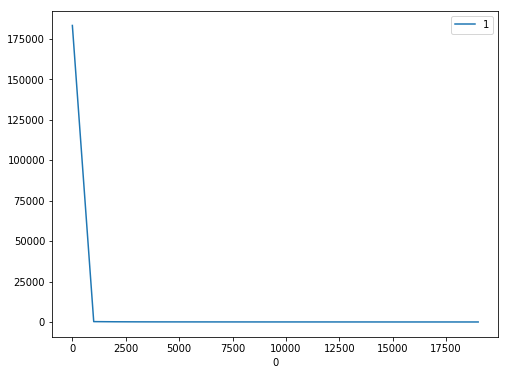

In [189]:
pop_df = pd.DataFrame(popularity_count)
pop_df = pop_df.set_index(pop_df[0])
pop_df = pop_df.drop(0, 1)
pop_df.plot(figsize=(8,6));

In [191]:
pop_df.head(15)

,1
0,
0,183400
1000,248
2000,152
3000,107
4000,84
5000,72
6000,65
7000,58
8000,53


### Let 9000 be the criteria.

In [224]:
popular_colors_count = pd.read_sql_query(
    'SELECT ' +
        'colorname, ' +
        'COUNT(*) AS number_entries ' +
    'FROM answers ' +
    'GROUP BY colorname ' +
    'HAVING number_entries > 9000 ' +
    'ORDER BY number_entries DESC; '
    , conn)
popular_colors_list = popular_colors_count['colorname'].tolist()

Now we've got a list of the 48 most common colors. What happens if we narrow down the (all the answers) data to only these responses?

In [244]:
answers = pd.read_sql_query('SELECT r,g,b,colorname FROM answers;', conn)
#answers['test'] = ""
#answers.loc[0,'colorname']

In [245]:
index_list = []
for i in range (0, len(answers)):
    if answers.loc[i,'colorname'] in popular_colors_list:
         index_list.append(i)

In [256]:
len(index_list)
some_answers = answers.iloc[index_list,:]

## K Neighbors Classifer

In [268]:
X = some_answers.drop(['colorname'],1)
y = some_answers[['colorname']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [272]:
np.sqrt(len(X_train))

1301.4514973674586

In [300]:
neigh = KNeighborsClassifier(n_neighbors=500)
neigh.fit(X_train, y_train) 

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=500, p=2,
           weights='uniform')

In [301]:
predict = (neigh.predict(X_test))

In [302]:
accuracy_score(y_pred=predict,y_true=y_test)

0.5568798781423797